In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import cftime

In [5]:
soil_type = "Clarion"
fert_amount = "123"
case = "MESOCOSM_" + soil_type + "_" + fert_amount +"kgN"
path = "/glade/scratch/jinmuluo/archive/"+case+"/lnd/hist/" 

case = "DerechoTest"
path = "/glade/derecho/scratch/jinmuluo/archive/DerechoTest/lnd/hist/"
start_date = date(2022, 1, 1)
end_date = date(2023, 1, 1)
NO_LEAP = True

# Because out model simulation results are in daily average
# delta_months = (end_date.year - start_date.year)*12 + end_date.month - start_date.month + 1
delta_days = (end_date - start_date).days

In [6]:
NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 
          'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
           'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", 
         "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]
Others = ["FAN_TOTN", "NITRATE_TOTN",'SMINN', 'SMINN_vr', 'SMIN_NH4_vr', 'SMIN_NO3_vr', 'H2OSOI', 'TSOI_10CM']

CLM = []
for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
        
    CLM.append(path + case + ".clm2." + "h1" + "." + currdate +"-00000.nc")

In [7]:
def preprocess(ds, fields=GAS):
    return(ds[fields])

dsCLM = xr.open_mfdataset(CLM, decode_times=True, preprocess=preprocess)

In [9]:
p2 = "/glade/work/jinmuluo/MESONET/measurements/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022.csv')

dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
#dsNO.index = [(x - datetime(1970, 1, 1)).days for x in dsNO.index]


In [10]:
dsN2O = pd.read_csv(p2+'mesocosm_ghg_flux_data_2022.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

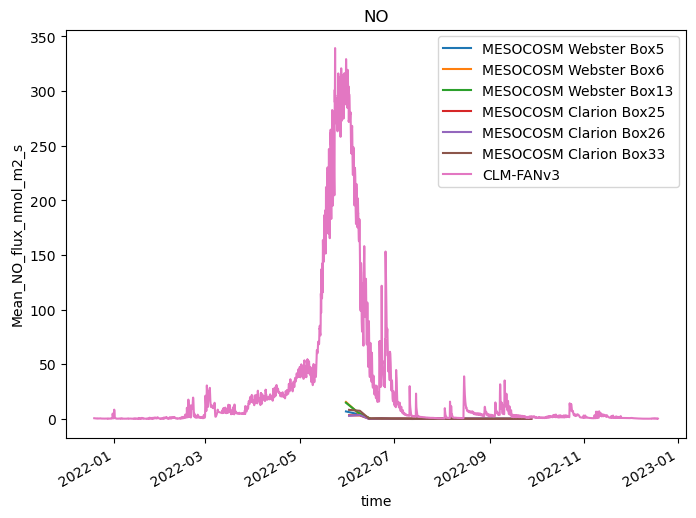

In [11]:
NO = (dsCLM.NOx_NITRIFY_TOTAL + dsCLM.NOx_DENITRIFY_TOTAL + dsCLM.F_NOx_NIT + dsCLM.F_NOx_DENIT)*1e9*30/14
NO.attrs['units'] = "nmol/m2/s"
#dsTIME = pd.DataFrame({'date':dsCLM.time.dt.strftime("%Y-%m-%d %H:%M:%S")})
NO['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO.time]

fig, ax = plt.subplots(figsize=(8, 6))
dsNO.loc[('Webster', 123, 5), 'Mean_NO_flux_nmol_m2_s'].plot(ax=ax, label='MESOCOSM Webster Box5')
dsNO.loc[('Webster', 123, 6), 'Mean_NO_flux_nmol_m2_s'].plot(ax=ax, label='MESOCOSM Webster Box6')
dsNO.loc[('Webster', 123, 13), 'Mean_NO_flux_nmol_m2_s'].plot(ax=ax, label='MESOCOSM Webster Box13')
dsNO.loc[('Clarion', 123, 25), 'Mean_NO_flux_nmol_m2_s'].plot(ax=ax, label='MESOCOSM Clarion Box25')
dsNO.loc[('Clarion', 123, 26), 'Mean_NO_flux_nmol_m2_s'].plot(ax=ax, label='MESOCOSM Clarion Box26')
dsNO.loc[('Clarion', 123, 33), 'Mean_NO_flux_nmol_m2_s'].plot(ax=ax, label='MESOCOSM Clarion Box33')
NO.plot(ax=ax, label='CLM-FANv3')

ax.set_title("NO")
ax.set_ylabel("Mean_NO_flux_nmol_m2_s")
ax.legend()
fig.savefig("NO_emission.jpg", dpi=200)
plt.show()

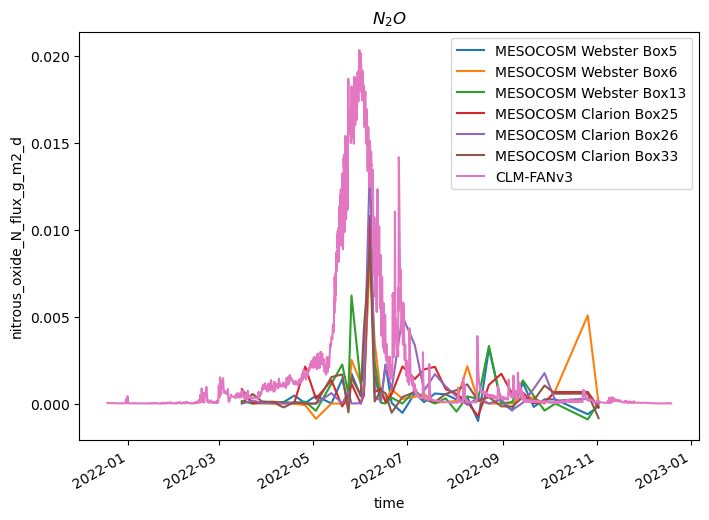

In [12]:
N2O = (dsCLM.N2O_NITRIFY_TOTAL + dsCLM.F_N2O_NIT + dsCLM.N2O_DENITRIFY_TOTAL+ dsCLM.F_N2O_DENIT)*24*3600
N2O.attrs['units'] = "gN/m2/d"
N2O['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in N2O.time]

fig, ax = plt.subplots(figsize=(8, 6))
dsN2O.loc[('Webster', 123, 'B5'), 'nitrous_oxide_N_flux_g_m2_d'].plot(ax=ax, label='MESOCOSM Webster Box5')
dsN2O.loc[('Webster', 123, 'B6'), 'nitrous_oxide_N_flux_g_m2_d'].plot(ax=ax, label='MESOCOSM Webster Box6')
dsN2O.loc[('Webster', 123, 'B13'), 'nitrous_oxide_N_flux_g_m2_d'].plot(ax=ax, label='MESOCOSM Webster Box13')
dsN2O.loc[('Clarion', 123, 'B25'), 'nitrous_oxide_N_flux_g_m2_d'].plot(ax=ax, label='MESOCOSM Clarion Box25')
dsN2O.loc[('Clarion', 123, 'B26'), 'nitrous_oxide_N_flux_g_m2_d'].plot(ax=ax, label='MESOCOSM Clarion Box26')
dsN2O.loc[('Clarion', 123, 'B33'), 'nitrous_oxide_N_flux_g_m2_d'].plot(ax=ax, label='MESOCOSM Clarion Box33')
N2O.plot(ax=ax, label='CLM-FANv3')

ax.set_title("$N_2O$")
ax.set_ylabel("nitrous_oxide_N_flux_g_m2_d")
ax.legend()
fig.savefig("N2O_emission.jpg", dpi=200)
plt.show()

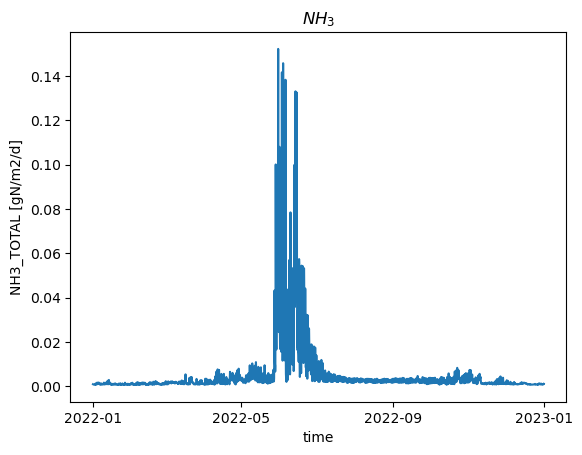

In [13]:
NH3 = dsCLM.NH3_TOTAL*24*3600
NH3.attrs['units'] = "gN/m2/d"
NH3.plot()
plt.title("$NH_3$")
plt.savefig("NH3_emission.jpg", dpi=200)
plt.show()

In [14]:
def preprocess(ds, fields=NInput):
    return(ds[fields])

dsCLM = xr.open_mfdataset(CLM, decode_times=True, preprocess=preprocess)

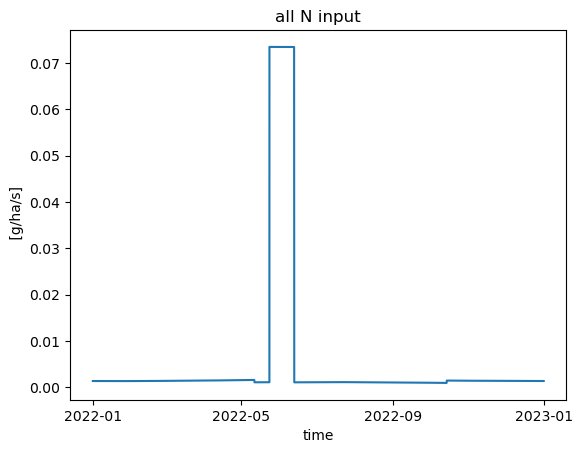

In [15]:
fert = (dsCLM.MANURE_N_GRZ + dsCLM.MANURE_N_BARNS + dsCLM.FERT_N_APP +  dsCLM.NFIX + dsCLM.NDEP_TO_SMINN )*1e4
fert.attrs['units'] = "g/ha/s"
fert.plot()
plt.title("all N input")
plt.savefig("N_input.png", dpi=200)
plt.show()

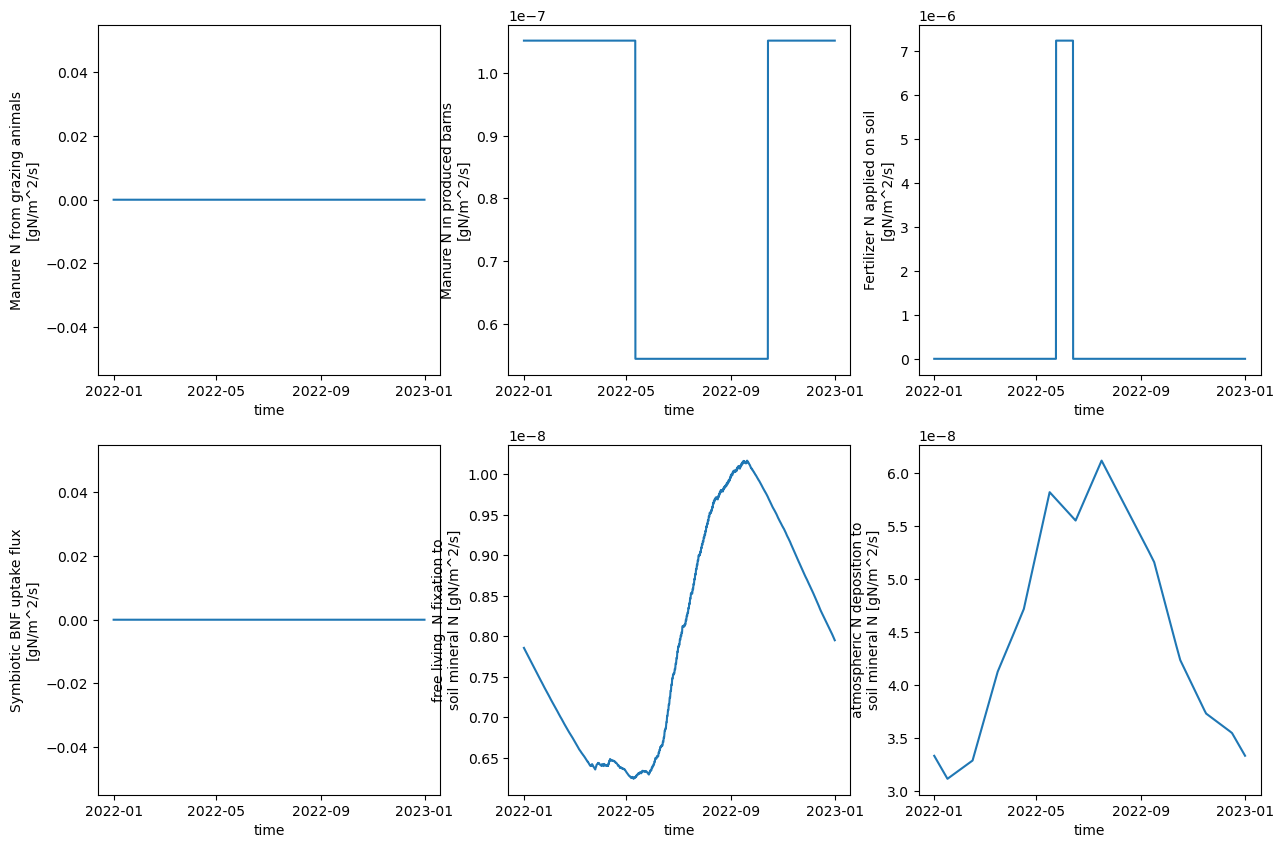

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
dsCLM.MANURE_N_GRZ.plot(ax=ax[0, 0]) 
dsCLM.MANURE_N_BARNS.plot(ax=ax[0, 1])  
dsCLM.FERT_N_APP.plot(ax=ax[0, 2])   
dsCLM.NFIX.plot(ax=ax[1, 0])  
dsCLM.FFIX_TO_SMINN.plot(ax=ax[1, 1]) 
dsCLM.NDEP_TO_SMINN.plot(ax=ax[1, 2]) 
plt.savefig("N_input2.png", dpi=200)

In [18]:
dsMESOCOSM = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/mescocosm_extracted_soil_nitrogen_2022.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

In [19]:
def preprocess(ds, fields=Others):
    return(ds[fields])

dsCLM = xr.open_mfdataset(CLM, decode_times=True, preprocess=preprocess)

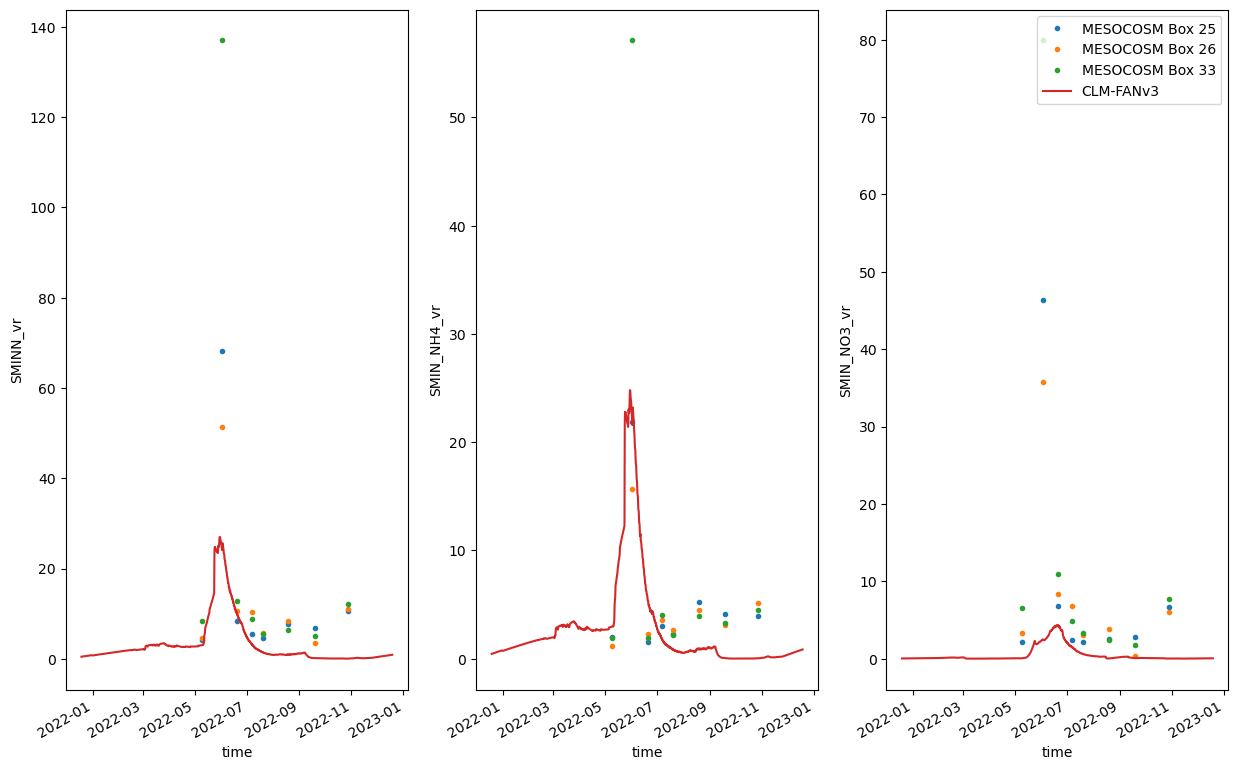

In [20]:
dsCLM['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in dsCLM.time]
a = dsCLM['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
a = a*1000/2650

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
dsMESOCOSM.loc[('Clarion', 123, 'B25'), 'soil_sminn'].plot(ax=ax[0], style='.', label='MESOCOSM Box 25')
dsMESOCOSM.loc[('Clarion', 123, 'B26'), 'soil_sminn'].plot(ax=ax[0], style='.', label='MESOCOSM Box 26')
dsMESOCOSM.loc[('Clarion', 123, 'B33'), 'soil_sminn'].plot(ax=ax[0], style='.', label='MESOCOSM Box 33')
a.plot(ax=ax[0], label='CLM-FANv3')

dsCLM['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM["FAN_TOTN"].values - dsCLM["NITRATE_TOTN"].values
b = dsCLM['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
b = b*1000/2650
dsCLM['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM["NITRATE_TOTN"].values
c = dsCLM['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
c = c*1000/2650

dsMESOCOSM.loc[('Clarion', 123, 'B25'), 'soil_ammonium_mgN_kg'].plot(ax=ax[1], style='.', label='MESOCOSM Box 25')
dsMESOCOSM.loc[('Clarion', 123, 'B26'), 'soil_ammonium_mgN_kg'].plot(ax=ax[1], style='.', label='MESOCOSM Box 26')
dsMESOCOSM.loc[('Clarion', 123, 'B33'), 'soil_ammonium_mgN_kg'].plot(ax=ax[1], style='.', label='MESOCOSM Box 33')
b.plot(ax=ax[1], label='CLM-FANv3')

dsMESOCOSM.loc[('Clarion', 123, 'B25'), 'soil_nitrate_mgN_kg'].plot(ax=ax[2], style='.', label='MESOCOSM Box 25')
dsMESOCOSM.loc[('Clarion', 123, 'B26'), 'soil_nitrate_mgN_kg'].plot(ax=ax[2], style='.', label='MESOCOSM Box 26')
dsMESOCOSM.loc[('Clarion', 123, 'B33'), 'soil_nitrate_mgN_kg'].plot(ax=ax[2], style='.', label='MESOCOSM Box 33')
c.plot(ax=ax[2], label='CLM-FANv3')

plt.legend()

In [22]:
dsSoil = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/mesocosm_ghg_flux_data_2022.csv")
dsSoil['date'] = pd.to_datetime(dsSoil['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsSoil['air_temperature_K'] = dsSoil['air_temperature_C'] + 273.15
dsSoil.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsSoil = dsSoil.sort_index()

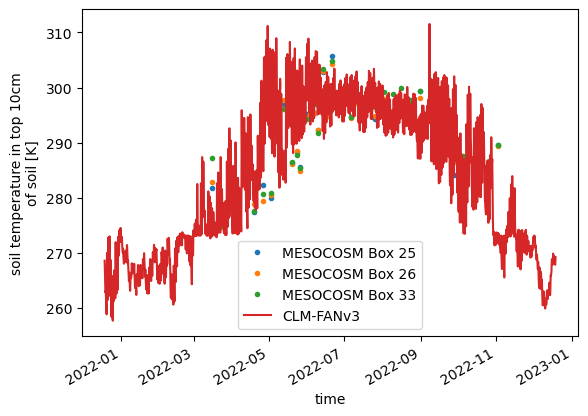

In [23]:
dsSoil.loc[('Clarion', 123, 'B25'), 'air_temperature_K'].plot(style='.', label='MESOCOSM Box 25')
dsSoil.loc[('Clarion', 123, 'B26'), 'air_temperature_K'].plot(style='.', label='MESOCOSM Box 26')
dsSoil.loc[('Clarion', 123, 'B33'), 'air_temperature_K'].plot(style='.', label='MESOCOSM Box 33')
dsCLM['TSOI_10CM'].plot(label='CLM-FANv3')
plt.legend()

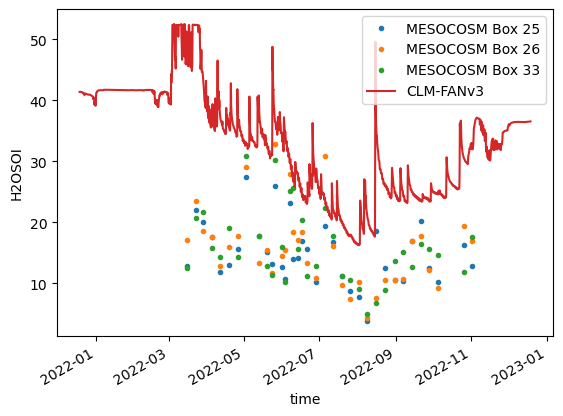

In [24]:
dsSoil.loc[('Clarion', 123, 'B25'), 'soil_moisture_volume_percent'].plot(style='.', label='MESOCOSM Box 25')
dsSoil.loc[('Clarion', 123, 'B26'), 'soil_moisture_volume_percent'].plot(style='.', label='MESOCOSM Box 26')
dsSoil.loc[('Clarion', 123, 'B33'), 'soil_moisture_volume_percent'].plot(style='.', label='MESOCOSM Box 33')
b = dsCLM['H2OSOI'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')*100
b.plot(label='CLM-FANv3')
plt.legend()

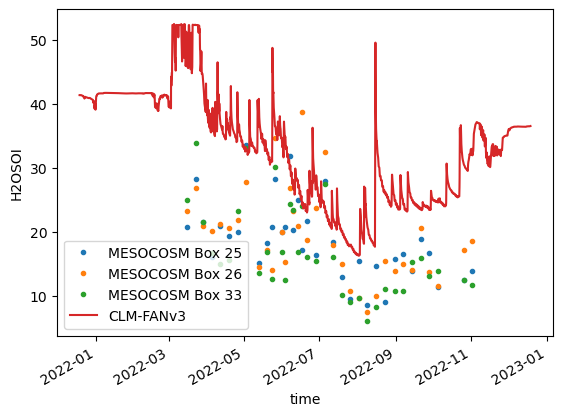

In [25]:
dsSoil.loc[('Webster', 123, 'B5'), 'soil_moisture_volume_percent'].plot(style='.', label='MESOCOSM Box 25')
dsSoil.loc[('Webster', 123, 'B6'), 'soil_moisture_volume_percent'].plot(style='.', label='MESOCOSM Box 26')
dsSoil.loc[('Webster', 123, 'B13'), 'soil_moisture_volume_percent'].plot(style='.', label='MESOCOSM Box 33')
b = dsCLM['H2OSOI'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')*100
b.plot(label='CLM-FANv3')
plt.legend()